In [3]:
import numpy as np
import torch
import torchvision as tv
import cv2
import matplotlib.pyplot as plt

Building visual intuitions for the what transformations are happening to the images

In [21]:
some_shape = (180, 240, 3)
some_size = some_shape[:2]
path = r"C:\Users\13463\OneDrive\Pictures\tumblr_0ea62a352230ab3d8e59de6e80a0c686_a45bb023_1280cropped.jpg"
image = cv2.imread(path)
other_shape = image.shape
other_size = other_shape[:2]
print(f"Image shape: {other_shape}")
print(f"Image size: {other_size}")
print(f"some_size: {some_size}")
i = np.random.randint(other_size[0] - some_size[0])
j = np.random.randint(other_size[1] - some_size[1])
print(f"Random indices: ({i}, {j})")



Image shape: (561, 1000, 3)
Image size: (561, 1000)
some_size: (180, 240)
Random indices: (217, 127)


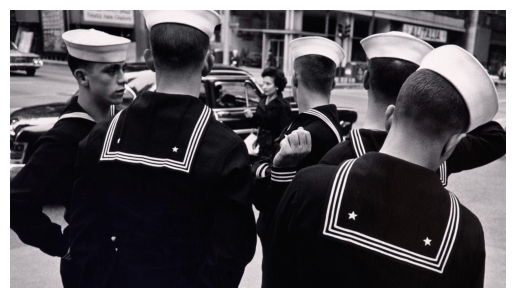

In [22]:
plt.imshow(image)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


torch.Size([3, 561, 1000])


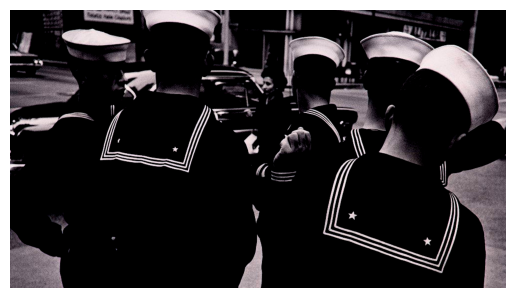

In [23]:
transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])
whole_new_image = transform(image)
#PyTorch tensor shape is (C, H, W) as opposed to (H, W, C) in OpenCV and numpy
print(whole_new_image.shape)
whole_new_image = whole_new_image.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(whole_new_image)
plt.axis('off')
plt.show()

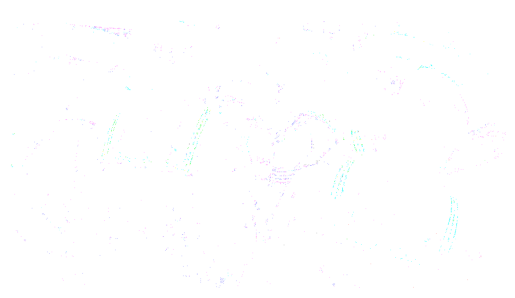

In [24]:
whole_new__image = np.moveaxis(whole_new_image, [0, 1, 2], [2, 0, 1])
image = (image + 1) / 2
image[image < 0] = 0
image[image > 1] = 1
plt.imshow(image)
plt.axis('off')
plt.show()

The transformations I made may make more sense on image stored as PIL Image rather than as a NumPy array(?)

In [4]:
import os
import nntools
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import time 

ModuleNotFoundError: No module named 'nntools.utils'

In [ ]:

class NNRegressor(nt.NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()
    
    def criterion(self, y, d):
        return self.mse(y, d)


# DnCNN class
### Variable 'D' represents depth of the work i.e. the number of hidden layers
### Variable 'C' represents the number of channels in a layer of the network. 
#### 1. Channels refer to the different feature dimensions present in the data passed between layers. 
#### 2. This model's first layer maps the information the three input channels -- namely, red, green, and blue channels -- to C=64 channel feature map. 
#### 3. It then has maps these 64 features to another 64 features along the D hidden layers of the network.
#### 4. Finally, it encodes those final 64 features back to the original 3 channels which we began with. 


In [ ]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y